<a href="https://colab.research.google.com/github/zxcx98738/Eddie-Hsieh/blob/master/2002TW_backtetsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **安裝talib**

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

## **安裝所需套件**


In [ ]:
!pip install twstock
!pip install yfinance
!pip install yfinance --upgrade --no-cache-dir
!pip install pandas_datareader
!pip install backtesting

## **引入所需套件**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Yahoo finance 套件，用來下載股價資訊
import yfinance as yf
from pandas_datareader import data as pdr
import datetime 
import pandas_datareader.data as web
from backtesting import Backtest, Strategy
from backtesting import set_bokeh_output

/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:47: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


## **引用yfinance套件尋找 中鋼 2008 年初至 2021 年 8 月底 之股票資料**

In [ ]:
yf.pdr_override()
start=datetime.datetime(2000, 1, 1)
end=datetime.datetime(2021, 8, 31)
df_2002 = yf.download('2002.TW',start,end) 
df_2002.reset_index(level=0, inplace=True)
df_2002.head()
# import yfinance as yf
# import pandas as pd

# def get_historical_data(ticker):
#   d = yf.Ticker(ticker)
#   df = d.history(period="max")
#   df.columns = df.columns.str.lower()
#   df.columns = pd.Series(df.columns).str.capitalize().values
#   return df.dropna()

# df = get_historical_data('2002.TW')
# df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,12.442045,13.074692,12.283880,13.074692,3.833012,151974952.0
1,2000-01-05,12.652927,12.863810,12.442045,12.652927,3.709367,64726455.0
2,2000-01-06,12.916533,13.180133,12.916533,12.916533,3.786646,159324499.0
3,2000-01-07,13.180133,13.285574,12.969251,13.021968,3.817555,123269645.0
4,2000-01-10,13.707339,13.707339,13.496457,13.601898,3.987570,147197117.0


## **去除 na 值及去掉成交量為 0 之項目**

In [ ]:
df_2002 = df_2002.dropna()
df_2002 = df_2002[df_2002['Volume'] != 0] 

## **計算均線**

In [ ]:
# change date to index 
df_2002['Date'] = pd.to_datetime(df_2002['Date'])
df_2002 = df_2002.set_index('Date')
# calculate MA 
df_2002['sma20'] = df_2002['Close'].rolling(20).mean()
df_2002['sma60'] = df_2002['Close'].rolling(60).mean()

In [ ]:
df_2002.head()

,Open,High,Low,Close,Adj Close,Volume,sma20,sma60
Date,,,,,,,,
2000-01-04,12.442045,13.074692,12.283880,13.074692,3.833012,151974952.0,NaN,NaN
2000-01-05,12.652927,12.863810,12.442045,12.652927,3.709367,64726455.0,NaN,NaN
2000-01-06,12.916533,13.180133,12.916533,12.916533,3.786646,159324499.0,NaN,NaN
2000-01-07,13.180133,13.285574,12.969251,13.021968,3.817555,123269645.0,NaN,NaN
2000-01-10,13.707339,13.707339,13.496457,13.601898,3.987570,147197117.0,NaN,NaN


## **撰寫策略：法一之** [參考連結](https://pixnashpython.pixnet.net/blog/post/42639436-%E3%80%90backtesting%E3%80%91python%E8%BC%95%E9%87%8F%E5%9B%9E%E6%B8%AC%E5%B7%A5%E5%85%B7-1%EF%BC%9Abacktesting%E5%9F%BA)
用 20 日均線及 60日 均線作為交易策略

In [ ]:
def I_Singal(value): # 使外部指標可以方便在init裡面套用 
    return value


class STRATEGY(Strategy):
    # 初始化
    def init(self):
        super().init()
        # 將均線指標用圖顯示出來
        self.sma20 = self.I(I_Singal, self.data.sma20) 
        self.sma60 = self.I(I_Singal, self.data.sma60)

    # 交易邏輯    
    def next(self):
        super().next()
        # 如果手上沒有部位 and 20 日均線 大於 60 日均線，買進 1000 單位
        if not self.position and (self.data.sma20 > self.data.sma60):
            # 買1000單位 不填表示用金額去買
            self.buy(size=1000) 
        # 如果手上有部位 and 20 日均線 小於 60 日均線，用 隔日開盤價 平倉    
        elif self.position.is_long and (self.data.sma20 < self.data.sma60):
            self.position.close()

In [ ]:
# 撰寫策略
bt = Backtest(df_2002, STRATEGY, cash=50000)
# 輸出策略
output = bt.run()

In [ ]:
bt.plot(relative_equity=False, plot_equity=True, plot_return=True, plot_volume=False, superimpose=True)
# relative_equity 權益及報酬 False 為 “金額” 表示 可改成 True 用 “百分比” 表示
# plot_equity 顯示權益曲線
# plot_return 顯示報酬率
# plot_volume 顯示量
# superimpose 顯示月k在背景

Row(id='1540', ...)

In [ ]:
# equity = output['_equity_curve']
# trades = output['_trades']
# equity.tail()

## **撰寫策略：法二之** [參考連結](https://www.finlab.tw/twii-2330-invest/)
用 20 日均線及 60日 均線作為交易策略

In [ ]:
import talib

# compute simple moving average using talib
sma1 = talib.SMA(df_2002.Close, timeperiod=20)
sma2 = talib.SMA(df_2002.Close, timeperiod=60)

# compute buy and sell signals (golden cross and death cross)
signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

# combine long and short signals
signal = signal_long.copy()
signal[signal_short] = -1

In [ ]:
# s = signal.to_frame()
# s.loc[s[0] == -1]

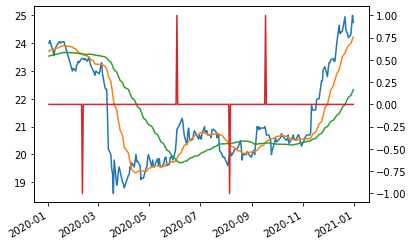

In [ ]:
# show the info in 2020
df_2002.Close['2020'].plot() # blue line : the stock close price of 2002
sma1['2020'].plot() # yellow line ：sma1, 20 MA line
sma2['2020'].plot() # green line : sma2, 60 MA Line
signal['2020'].astype(int).plot(secondary_y=True) # red line: signal of buy and sell

## **進行回測**

In [ ]:
from backtesting import Backtest, Strategy

class Strategy(Strategy):
    
    n1 = 20
    n2 = 60
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        sma1 = talib.SMA(close, timeperiod=self.n1) 
        sma2 = talib.SMA(close, timeperiod=self.n2)

        # Precompute signal
        signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
        signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot sma
        self.I(lambda x: sma1, 'sma1')
        self.I(lambda x: sma2, 'sma2')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]

        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
          for trade in self.trades:
              trade.close()

bt = Backtest(df_2002, Strategy)
result1 = bt.run()
bt.plot()

Row(id='2389', ...)

*   圖一：

  藍色線為最後的績效，也代表策略報酬率，從2000到現在可以獲利約486％，而紅色線段代表最久沒有創新高的時間，這段時間會讓使用者懷疑策略有沒有效果，從而放棄策略。
*   圖二：

  正三角是做多，倒三角是做空

  顏色代表獲利或是虧損，綠色為獲利，紅色為虧損，三角形的高度代表獲利或虧損的程度
  
  以虛線做區分，虛線上方是獲利，而虛線下方式虧損
*   圖三：

  是交易明細，除了股價 K 棒外，我們也看到了兩條均線（藍色跟橘色），方便核對交易的時間，另外我們可以看到綠色和紅色的虛線，每一條虛線都代表一次交易，虛線的起始和結束，代表交易的價格跟時間，綠色代表獲利，而紅色代表虧損。

*   圖四及圖五，則是成交量以及 signal 訊號，此策略就是模擬 signal 訊號為 1 時買進，而 -1 時賣出

In [ ]:
result2 = bt.optimize(n1=range(10, 240, 10), # 10日 MA, 240 日 MA（年線）, 參數間隔
                      n2=range(10, 240, 10))
result2._strategy
# 最佳化參數
# 也可將參數間隔改為5, 但實測發現跑的時間過長，且有可能因此導致overfitting
# 結果：<Strategy Strategy(n1=20,n2=50)>, 適合月線及 50 日均線

/usr/local/lib/python3.7/dist-packages/backtesting/backtesting.py:1487: UserWarning: Searching for best of 529 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

<Strategy Strategy(n1=20,n2=50)>

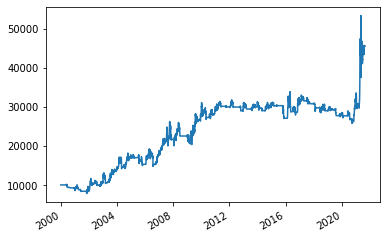

In [ ]:
((result1._equity_curve.Equity + 
result2._equity_curve.Equity)/2).plot()

## **多檔股票回測（未完）** 
五檔鋼鐵股
中鋼 2002.TW／燁興 2007.TW／中鋼構 2013.TW／燁輝 2023.TW／盛餘 2029.TW


## 為何需要多檔股票回測
當寫完策略後，只要通過優化參數的方法，便可以得到不錯的績效，但有可能發生的狀況是，優化只針對到歷史的部分，並沒有優化到未來，大致可以歸因於以下幾點
*   參數維度太多、太大，樣本卻不足，策略誤將歷史雜訊當成規律來優化（overfitting）
*   策略雖然有抓到股價的型態，但是隨著越來越多人用一樣的策略，導致市場效率上升，獲利空間被壓縮
*   商品因為基本面和消息面、黑天鵝事件，有重大的變化，導致價格的特性跟以往不一樣。如 2021 年前半年航運股及鋼鐵股的漲幅

## 要如何避免 overfitting 呢？
*   不使用過多參數，或是參數盡量重複使用，讓可調整的維度盡量縮小。
*   避免盲目的修改程式碼並回測的過程，如大於改成小於，參數隨意改再測一次等等
*   取不同的商品，將所有商品用同一個策略來優化
*   驗證近期績效，假如是是選股策略，一定要將兩三年的績效，跟大盤做比較，才能確保策略在近年是有效的


In [ ]:
import yfinance as yf
import pandas as pd

def get_historical_data(ticker):
  d = yf.Ticker(ticker)
  df = d.history(period="max")
  df.columns = df.columns.str.lower()
  df.columns = pd.Series(df.columns).str.capitalize().values
  return df.dropna()

stocks = ['2002.TW', '2007.TW', '2013.TW', '2023.TW','2029.TW']
dfs = {s:get_historical_data(s) for s in stocks}